# SEN122A Statistical Analysis of Choice Behaviour 

## `Lab session 02B:`
## `The Mixed Logit model`

**Delft University of Technology**<br>
**Q2 2025**<br>
**Instructor:** Sander van Cranenburgh<br>
**TA:**  Gabriel Nova <br>

### `Instructions`

**Lab sessions aim to:**<br>
* Illustrate how models and theory discussed in the classroom work out in practice.
* Help you gather hands-on modelling and data analysis skills.


**Lab sessions are:**<br>
* Learning environments where you work with Python and get support from TA and fellow students.
* Not graded and do not have to be submitted.
* A good preparation for the graded partial exam.

### `Application: Estimating the Value of Travel Time`

In this lab session, we will investigate the "Value of Travel Time" (VTT) distribution. The VTT of a traveller reflects the amount of money the traveller is **willing to pay** to reduce their travel time. The VTT is used to determine the benefits of new infrastructure projects. As travel time savings are the dominant and most salient benefits of new infrastructure, accurate inference of the distribution of the VTT is crucial for a rigorous underpinning of policy decisions. <br>

During this lab, we will apply Mixed Logit choice models. We aim to uncover how tastes for travel time and travel cost are distributed in the population. Most of the analyses in this lab session are carried out in the so-called willingness-to-pay space. Willingness-to-pay space facilitates the inference of the VTT distribution.<br>

For this study, we will use Stated Choice (SC) data (`Norway_VTT_2009.csv`) collected in 2009 to compute the Norwegian VTT. In this SC experiment, respondents faced nine choice tasks involving two alternatives and two attributes (travel cost and travel time). The data set consists of 5,832 participants, resulting in a total of 52,488 choice observations. The figure below shows one of the choice tasks (note that for the purposes of illustration we converted the currency unit (Kronor) into euros).

![SC](assets/sc_experiment.png)

**`Learning objectives lab session 02B`**

After completing the following exercises, you will be able to:
* Estimate Mixed Logit models that account for panel data
* Discuss the impact of the number of draws on the modelling outcomes


**`This lab consists of 2 parts and has 2 exercises`**

**Part 1**: The Panel Mixed Logit model

- Exercise 1: "Panel MXL model with log-normally distributed VTT"

**Part 2**: Impact of the number of draws on modelling outcomes

- Exercise 2: "Impact of the number of draws"



### `Import packages`

To begin, we will import all the libraries that we will use in this lab.

In [4]:
# Biogeme
import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.biogeme_logging as blog
from biogeme import models
from biogeme.expressions import Beta, Variable, bioDraws, log, MonteCarlo, exp, bioMultSum, exp

# General packages
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import time
from pathlib import Path
from scipy.stats import norm, lognorm

# Pandas setting to show all columns when displaying a pandas dataframe
pd.set_option('display.max_columns', None)

In [5]:
# Add the utils folder to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

# Import the bio_estimation_fcns from the utils folder
from utils.bio_estimation_fcns import print_results, estimate_panel_mxl, plot_distributions

We invoke a so-called `logger` which enables us to see the progress during estimation.<br>

In [6]:
# Initialize the logger, if it has not been initialized yet
try:
    logger
except NameError:    
    logger = blog.get_screen_logger(level=blog.INFO)
    print('Logger has been initialised')

Logger has been initialised


## `1. Load and explore the data set` <br>

We will use the same data set as in lab session 2A. So,we load the data and process it similarly as in lab session 2A.

In [7]:
# 1. Load the data set
data_path = Path('data/Norway_VTT_2009.csv')
df = pd.read_table(data_path, sep=',')

In [8]:
# 1. Keep only entries purpose == 5 (Long distance trips) & Mode == 1 (Car)
df = df.loc[(df['Purpose'] == 5) & (df['Mode'] == 1)]

# Keep only the relevant columns
df.drop(columns=['Mode','Purpose', 'Gender', 'AgeClass', 'IncClass'], inplace=True)

In [9]:
# 2. Convert the monetary unit to euros
NOK2euro_exchange_rate = 9
df[['CostL','CostR']] = df[['CostL','CostR']] .div(NOK2euro_exchange_rate)

## `1. The Panel Mixed Logit model`

Thus far, we have worked on the assumption that each choice observation is uncorrelated with all other choice observations. However, this data set contains multiple choices per respondent. In the MXL modelling framework, we can also account for correlation in unobserved utility **across observations** of the same individual if we specify it as a panel MXL model. In the panel MXL model, the likelihood of the sequence of choices *t* = 1..*T* of an individual *n* is given by:  

$L_n(i_1,...,i_{T})(\beta_n|\sigma) = \int_{\beta_n}\Pi_{t=1}^T     P_{n}(i_t|\beta_n) f(\beta_n|\sigma)d\beta_n$

This likelihood does not have a closed-form expression. Therefore, as before, it needs to be approximated using simulation. Let's re-estimate the MXL model assuming a normally distributed VTT distribution while accounting for panel structure. To do this, we first need to convert the data set into a so-called wide data format. In a wide format data set, each row contains all the choices belonging to an individual. Conveniently, Biogeme has a built-in function to do this (but, rather inconveniently, the names of the columns still need to be renamed).

### `1.1. Preparing a wide Biogeme database for estimating panel MXL model`

In this cell we transform our data set into a wide format, and create a new Biogeme database object.

In [10]:
# Create Biogeme database object
biodata = db.Database('Norway2009VTT', df)

# Tell Biogeme which variable is the identifier of the individuals
biodata.panel('RespID')

# Calculate the number of observations per individual
obs_per_ind = biodata.data['RespID'].value_counts().unique()[0]
print(f'Number of observations per individual: {obs_per_ind}')

# Use biogeme's "generateFlatPanelDataFrame to create a wide database in which each row corresponds to one individual
df_wide = biodata.generate_flat_panel_dataframe(identical_columns=None)

# Rename the columns, such that they run from columnname_{0} to columnname_{n} 
renumbered_columns = {col: f'{col.split("_")[1]}_{int(col.split("_")[0])-1}' if len(col.split("_")) == 2 else col for col in df_wide.columns}

# Rename the columns using the dictionary
df_wide.rename(columns=renumbered_columns, inplace=True)

# list of df_wide.columns excluding the columns that start with 'Cost'
col_in = df_wide.columns[df_wide.columns.str.startswith('Cost') == False].tolist()
# Convert the columns that do not start with 'Cost' to integers
for col in col_in:
    df_wide[col] = df_wide[col].astype(int)

# Create Biogeme database object
biodata_wide = db.Database('Norway2009VTT_wide', df_wide)

# Show the first rows of the wide database
print(f'The wide dataset has a shape of {biodata_wide.data.shape}')
biodata_wide.data.head()

Number of observations per individual: 9
The wide dataset has a shape of (1214, 45)


,Chosen_0,CostL_0,CostR_0,TimeL_0,TimeR_0,Chosen_1,CostL_1,CostR_1,TimeL_1,TimeR_1,Chosen_2,CostL_2,CostR_2,TimeL_2,TimeR_2,Chosen_3,CostL_3,CostR_3,TimeL_3,TimeR_3,Chosen_4,CostL_4,CostR_4,TimeL_4,TimeR_4,Chosen_5,CostL_5,CostR_5,TimeL_5,TimeR_5,Chosen_6,CostL_6,CostR_6,TimeL_6,TimeR_6,Chosen_7,CostL_7,CostR_7,TimeL_7,TimeR_7,Chosen_8,CostL_8,CostR_8,TimeL_8,TimeR_8
RespID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
289,1,31.444444,28.666667,76,95,2,25.333333,28.666667,95,78,1,28.666667,24.555556,95,117,1,28.666667,50.333333,108,95,1,23.111111,28.666667,95,68,1,28.666667,42.333333,95,74,1,14.333333,28.666667,81,67,1,22.444444,28.666667,108,95,1,28.666667,57.333333,123,95
432,2,38.111111,45.666667,200,180,1,49.000000,45.666667,180,198,1,45.666667,68.888889,214,180,2,25.111111,45.666667,231,180,2,22.888889,45.666667,153,102,1,51.000000,45.666667,149,180,2,22.888889,45.666667,180,136,2,22.888889,45.666667,180,142,2,91.333333,45.666667,131,180
590,2,29.222222,36.000000,122,105,1,18.000000,36.000000,122,105,1,38.555556,36.000000,105,120,1,36.000000,72.000000,105,80,1,18.000000,36.000000,105,81,1,18.000000,36.000000,105,74,2,36.000000,37.333333,105,90,1,38.555556,36.000000,121,136,1,43.111111,36.000000,105,133
731,2,100.000000,104.333333,299,270,1,121.666667,100.000000,204,270,1,116.000000,100.000000,270,314,2,100.000000,68.000000,185,230,2,100.000000,65.333333,225,270,1,50.000000,100.000000,331,270,1,100.000000,97.888889,270,345,1,50.555556,100.000000,270,201,1,100.000000,155.111111,270,231
761,1,23.000000,31.111111,110,85,2,23.000000,26.222222,129,110,1,16.888889,23.000000,110,94,2,23.000000,13.111111,110,122,1,11.555556,23.000000,110,88,1,23.000000,46.000000,141,110,1,26.888889,23.000000,78,110,1,23.000000,46.000000,145,126,2,23.000000,11.555556,110,128


In [11]:
# Make dictionaries with the Biogeme variables from the wide database
CostL   =   {q: Variable(f'CostL_{q}') for q in range(obs_per_ind)}
TimeL   =   {q: Variable(f'TimeL_{q}') for q in range(obs_per_ind)}
CostR   =   {q: Variable(f'CostR_{q}') for q in range(obs_per_ind)}
TimeR   =   {q: Variable(f'TimeR_{q}') for q in range(obs_per_ind)}
CHOICE  =   {q: Variable(f'Chosen_{q}') for q in range(obs_per_ind)}

# Inspect one of the dictionaries
CHOICE

{0: Chosen_0,
 1: Chosen_1,
 2: Chosen_2,
 3: Chosen_3,
 4: Chosen_4,
 5: Chosen_5,
 6: Chosen_6,
 7: Chosen_7,
 8: Chosen_8}

### `1.2. Panel MXL model with normally distributed VTT`

In [12]:
# Give the model a name
model_name = 'Panel MXL WTP space with normally distributed vtt'

# Parameters definition enabling the construction of random parameters
vtt       = Beta('vtt',       0.4, None, None, 0)
B_tc      = Beta('b_tc',     -0.4, None, None, 0)    
sigma_vtt = Beta('sigma_vtt',   2, None, None, 0)

# Construction of random parameters   
vtt_rnd = vtt + sigma_vtt * bioDraws('vtt_rnd', 'NORMAL_HALTON2')

# Definition of the utility functions
# Note that we use list comprehension to create a list of utility functions for all observations of an individual 
V_L = [B_tc * (CostL[q] + vtt_rnd * TimeL[q]) for q in range(obs_per_ind)]
V_R = [B_tc * (CostR[q] + vtt_rnd * TimeR[q]) for q in range(obs_per_ind)]

# Create a dictionary to list the utility functions with the numbering of alternatives
# Note that we use list comprehension to create a list of dictionaries
V = [{1: V_L[q], 2: V_R[q]} for q in range(obs_per_ind)]
           
# Create a dictionary to describe the availability conditions of each alternative
AV = {1:1, 2:1}

In [13]:
# Estimate the model using the estimate_panel_mxl function
results_wtp_panel_mxl_normal = estimate_panel_mxl(V,AV,CHOICE,obs_per_ind,biodata_wide,model_name,num_draws = 100)

# Print the results
print_results(results_wtp_panel_mxl_normal)

Biogeme parameters read from biogeme.toml. 
The number of draws (100) is low. The results may not be meaningful. 
Optimization algorithm: hybrid Newton/BFGS with simple bounds [simple_bounds] 
** Optimization: Newton with trust region for simple bounds 
Iter.            b_tc       sigma_vtt             vtt     Function    Relgrad   Radius      Rho      
    0            -0.4               2             0.4      7.2e+03       0.67      0.5      -12    - 
    1            -0.4               2             0.4      7.2e+03       0.67     0.25     -2.6    - 
    2           -0.15             1.8            0.15      6.1e+03       0.17     0.25     0.83    + 
    3           -0.11             1.5            0.16        6e+03       0.12      2.5     0.95   ++ 
    4           -0.21              -1            0.24      5.7e+03       0.34      2.5     0.11    + 
    5           -0.21              -1            0.24      5.7e+03       0.34      1.2   -0.073    - 
    6           -0.13           



Results for model Panel MXL WTP space with normally distributed vtt
Nbr of parameters:		3
Sample size:			1214
Excluded data:			0
Null log likelihood:		-7573.326
Final log likelihood:		-5151.161
Likelihood ratio test (null):		4844.331
Rho square (null):			0.32
Rho bar square (null):			0.319
Akaike Information Criterion:	10308.32
Bayesian Information Criterion:	10323.63

            Value  Rob. Std err  Rob. t-test  Rob. p-value
b_tc      -0.1890        0.0088       -21.53           0.0
sigma_vtt  0.3109        0.0140        22.19           0.0
vtt        0.3097        0.0099        31.38           0.0


In [14]:
# Compute the value of travel time
beta_hat_wtp_panel_mxl_normal = results_wtp_panel_mxl_normal.get_beta_values()
VTT_wtp_panel_mxl_normal = 60 * beta_hat_wtp_panel_mxl_normal['vtt']
print(f'Value of travel time Panel MXL model in WTP space:  €{VTT_wtp_panel_mxl_normal:.2f} per hour')

Value of travel time Panel MXL model in WTP space:  €18.58 per hour


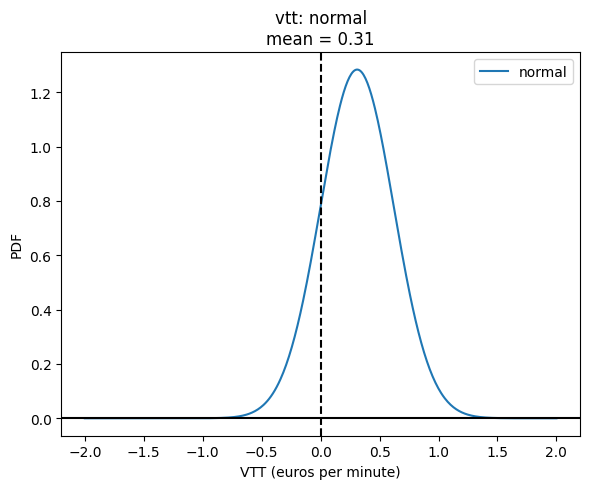

In [15]:
# Visualise the distribution of the VTT distribution
# Create the dictionary with the distribution types
distr_types = {
    'vtt':  {'dist': 'normal'},
}
# Plot the distributions of the random parameters, by passing it the biogeme results, the dictionary with the distribution types, and the x-axis limits
# Note that the unit of the VTT distribution is euros per minute
plot_distributions(results_wtp_panel_mxl_normal, distr_types, xmin = -2, xmax = 120/60, xlabel='VTT (euros per minute)')

## `Exercise 1: Panel MXL with log-normally distributed VTT`

Now, **you** will estimate a MXL model under the assumption that the VTT is log-normally distributed, while accounting for panel effects.<br>

To do so, copy the code from the Panel MXL model in WTP space with normally distributed VTT, and create the log-normally distributed random parameter (as you have done in exercise 2 of lab_session 2A).<br>  
Estimate this model and interpret the results.<br>


`A` Compare the log-likelihood of the MXL models with the log-normally distributed VTTs, which do and do not account for the panel effect. Which model fits better?<br>

`B` Compute the mean of the VTT for the Panel MXL model with the log-normally distributed VTT and compare it with the non-panel model. Has it changed?<br>

`C`  i. Print the recovered mean VTTs of the models we have estimated below each other.<br>
* MNL model<br>
* MXL model with Normal distribution in utility space<br>
* MXL model with Normal distribution in wtp space<br>
* MXL model with Log-normal in wtp space<br>
* Panel MXL with Normal distribution in wtp space<br>
* Panel MXL with Log-normal distribution in wtp space<br>                     

ii. Compare the VTTs of the models with a normal distribution and a log-normal distribution. Do you see a pattern? <br>

iii. What could explain this pattern?<br> 

#### `Answers`

In [16]:
# Give the model a name
model_name = 'Panel MXL WTP space with log-normally distributed vtt'

# Parameters definition enabling the construction of random parameters
mu_vtt    = Beta('mu_vtt',       0.4, None, None, 0)
B_tc      = Beta('b_tc',        -0.4, None, None, 0)    
sigma_vtt = Beta('sigma_vtt',      2, None, None, 0)

# Construction of random parameters   
vtt_rnd = exp(mu_vtt + sigma_vtt * bioDraws('vtt_rnd', 'NORMAL_HALTON2'))

# Definition of the utility functions
V_L = [B_tc * (CostL[q] + vtt_rnd * TimeL[q]) for q in range(obs_per_ind)]
V_R = [B_tc * (CostR[q] + vtt_rnd * TimeR[q]) for q in range(obs_per_ind)]

# Create a dictionary to list the utility functions with the numbering of alternatives
V = [{1: V_L[q], 2: V_R[q]} for q in range(obs_per_ind)]
           
# Create a dictionary to describe the availability conditions of each alternative
AV = {1:1, 2:1}

In [17]:
# Estimate the model using the estimate_panel_mxl function
results_wtp_panel_mxl_lognormal = estimate_panel_mxl(V,AV,CHOICE,obs_per_ind,biodata_wide,model_name,num_draws = 100)

# Print the results
print_results(results_wtp_panel_mxl_lognormal)

Biogeme parameters read from biogeme.toml. 
The number of draws (100) is low. The results may not be meaningful. 
Optimization algorithm: hybrid Newton/BFGS with simple bounds [simple_bounds] 
** Optimization: Newton with trust region for simple bounds 
Iter.            b_tc          mu_vtt       sigma_vtt     Function    Relgrad   Radius      Rho      
    0            -0.4             0.4               2      6.6e+03       0.65      0.5     -5.6    - 
    1            -0.4             0.4               2      6.6e+03       0.65     0.25     -4.1    - 
    2           -0.15            0.15             2.2      5.9e+03        0.3     0.25     0.71    + 
    3           -0.18            -0.1             2.3      5.7e+03      0.057      2.5        1   ++ 
    4           -0.18            -2.6             1.9      5.4e+03        0.1      2.5     0.73    + 
    5           -0.18            -2.6             1.9      5.4e+03        0.1      1.2     -3.1    - 
    6           -0.19           



Results for model Panel MXL WTP space with log-normally distributed vtt
Nbr of parameters:		3
Sample size:			1214
Excluded data:			0
Null log likelihood:		-7573.326
Final log likelihood:		-5120.652
Likelihood ratio test (null):		4905.348
Rho square (null):			0.324
Rho bar square (null):			0.323
Akaike Information Criterion:	10247.3
Bayesian Information Criterion:	10262.61

            Value  Rob. Std err  Rob. t-test  Rob. p-value
b_tc      -0.1976        0.0093       -21.28           0.0
mu_vtt    -1.3767        0.0345       -39.96           0.0
sigma_vtt  0.8341        0.0368        22.65           0.0


In [18]:
beta_hat_wtp_panel_mxl_lognormal = results_wtp_panel_mxl_lognormal.get_beta_values()
mu = beta_hat_wtp_panel_mxl_lognormal['mu_vtt']
sigma = beta_hat_wtp_panel_mxl_lognormal['sigma_vtt']
VTT_wtp_panel_mxl_lognormal = np.exp(mu + np.square(sigma)/2) * 60
print(f'The mean of the log-normal VTT distribution is: €{VTT_wtp_panel_mxl_lognormal:.2f} per hour')

The mean of the log-normal VTT distribution is: €21.45 per hour


`A` Compare the log-likelihood of the MXL model in WTP space with the log-normal distribution taking into account random taste parameters and panel effects. Which model fits better?<br>

        --> The MXL accounting panel effects fits better, as it has a higher log-likelihood (-5120 vs -5150) (number may vary slightly due to simulation error).


`B` Compute the mean of the log-normal dsitribution based on your estimated $\mu$ and $\sigma$ and compare it with the non-panel model. Has it changed?. <br>

        --> The mean of the log-normal VTT distribution for the panel model is: ~€21 per hour, while the mean of the log-normal VTT distribution for the non-panel model is above €25 per hour. Hence, the estimated VTT is considerably affected (lowered) by accounting for the panel structure of the data.

`C` i. Have a look at the recovered mean VTTs of the models that we have estimated: 

In [19]:
print(f'1 MNL model:\t\t\t\t\t\t\t\t€18.96 per hour')
print(f'2 Mixed Logit model - util space - with Normal distribution:\t\t~€18 per hour')
print(f'3 Mixed Logit model - wtp  space - with Normal distribution:\t\t~€18 per hour')
print(f'4 Mixed Logit model - wtp  space - with Lognormal distribution:\t\t~€26 per hour')
print(f'5 Panel Mixed Logit model - wtp space - with Normal distribution:\t€{VTT_wtp_panel_mxl_normal:.2f} per hour')
print(f'6 Panel Mixed Logit model - wtp space - with Lognormal distribution:\t€{VTT_wtp_panel_mxl_lognormal:.2f} per hour')

1 MNL model:								€18.96 per hour
2 Mixed Logit model - util space - with Normal distribution:		~€18 per hour
3 Mixed Logit model - wtp  space - with Normal distribution:		~€18 per hour
4 Mixed Logit model - wtp  space - with Lognormal distribution:		~€26 per hour
5 Panel Mixed Logit model - wtp space - with Normal distribution:	€18.58 per hour
6 Panel Mixed Logit model - wtp space - with Lognormal distribution:	€21.45 per hour


`C` ii. Compare the VTTs of the models with a normal distribution and a log-normal distribution. Do you see a pattern? <br>

        --> The models with the assumption that the VTT is log-normally distributed tend to yield a higher estimate of the mean VTT.

   iii. What could explain this pattern?

        --> This is caused by:
        * the fat tail of the log-normal distribution
        * the fact in contrast to the normal distribution, it does not have mass at the negative side.
        Both effects result in a shift of the mean to the right (higher). 

## `2. Impact of the number of draws on modelling outcomes`

## `Exercise 2: Impact of the number of draws` 

For all the Mixed Logit models that we have estimated, we have used a low number of draws (`num_draws = 100`). We choose a relatively low number of draws to avoid long estimation times.  <br>

Next, we analyse how sensitive the modelling outcomes are towards the number of draws. To do this, we have estimated a Panel Mixed Logit model using different numbers of draws, ranging from 33 to 2,000, and stored the results. <br>

The following plots show the results. 

![Draws](assets/draws_vs_.png)

`Questions:`

`A` The left-hand side plot shows that the VTT estimate gets more stable with an increasing number of draws. Can you explain why the estimate gets more stable? 

`B` What number of draws do you deem sufficient for estimating this model? Explain your answer.

`C` The right-hand side plot shows a linear relation between the number of draws and the estimation time. Explain why a linear relation was to be expected.

`D` Suppose we estimate a model with *K* random parameters. Would the relation between the number of draws and estimation time still be linear? Explain your answer. 

<br>

#### `Answers`

`A` ... Can you explain why the estimate gets more stable?<br>

        --> The approximation of the integral gets more and more accurate with increasing number of draws. This stabilises the estimates.
`B` What number of draws is sufficient? Explain your answer

        --> Above 500 draws, the results are stable. But the variance keeps reducing with more draws.

`C` ... Explain why a linear relation was to be expected.

        --> The number of computations is one-to-one related to the number of draws. And, the number of draws does not systematically seem to affect the number of iterations the optimiser needs to converge. Therefore, we see a linear relationship between the number of draws and estimation time.

`D` ... Would the relation between the number of draws and estimation time still be linear? 

        --> The estimation time will linearly scale with the number of random parameters, as the number of computations is one-to-one related to the number of random parameters. 


## END